# CNN for Classification
---
In this notebook, we define **and train** an CNN to classifiy images from the [Fashion-MNIST database](https://github.com/zalandoresearch/fashion-mnist).

### Load the data
In this cell, we load in both **training and test** datasets from the FashionMNIST class.

In [19]:
# our basic libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


In [20]:
# prepare data loaders, set the batch_size
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

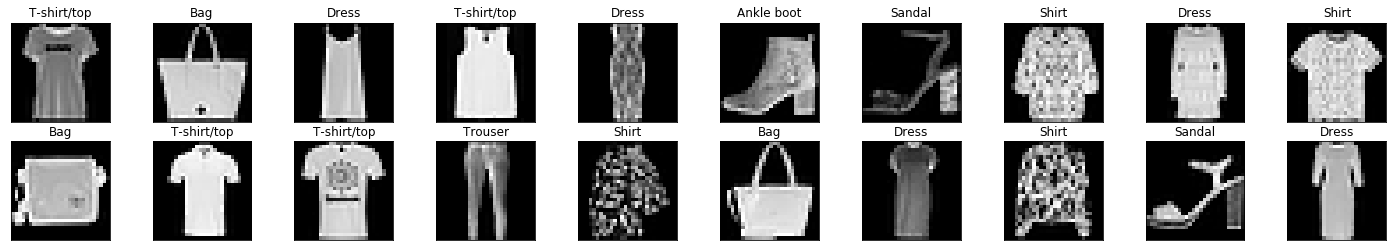

In [21]:

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

### Define the network architecture
The various layers that make up any neural network are documented, [here](http://pytorch.org/docs/master/nn.html).
For a convolutional neural network, we'll use a simple series of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected (linear) layers

You are also encouraged to look at adding [dropout layers](http://pytorch.org/docs/stable/nn.html#dropout) to avoid overfitting this data.
---
To define an neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employes those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autogra to calculate the update to the weights in the network.

#### DEfine the Layers in `__init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2,2)
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to ti before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

You must place any layers with trainable weights, such as convolutional layers, in the `__init__` function and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation functiom, may appear in either the `__init__` or the `forward` function. In practice, you'll often see conv/pool layers defined in `__init__` and activation defined in `forward`.

#### Convolutional layer
The first convolution layer has been defined for you, it takes in a 1 channel(grayscale) image and outputs 10 feature maps as output, after convolving the image with 3x3 filters.

#### Flattening
Recall that to move from the output of a convolutional/pooling layer to a linear layer, you must first flatten your extracted features into a vector. If you've used the deep learning library, Keras, you may have seen this done by Flatten(), and in PyTorch you can flatten as input x with x = x.view(x.size(0), -1)

#### TODO: Define the rest of the layers
It will be up to you to difine the other layers in this network; we have some recommendations, but you may change the architecture and parameters as you see fit.

Recommendations/tips:
* Use at least two convoutional layers
* Your output must be a linear layer with 10 outputs (for the 10 classes of clothing)
* Use a dropout layer to avoid overfitting

#### A note on output size
For any convolutinal layer, the output feature maps will have the specified depth (a depth of 10 for 10 filters in a convolutional layers) and the dimensions of the produced feature maps (width/height) can be computed as the input image width/height, W, minus the filter size, F, divided by the stride, S, all + 1. The equation looks like: output_dim = (W-F)/S + 1, for an assumed padding size of 0. You can find a derivation of this formula, [here](http://cs231n.github.io/convolutional-networks/#conv)

For a pool layer with a size 2 and stride 2, the output dimension will be reduced by a factor of 2. Read the comments in the code below to see the output for each layer.


In [22]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        ## output size = (W-F)/S +1 = (28-3)/1 +1 = 26
        # the output Tensor for one image, will have the dimensions: (10, 26, 26)
        # after one pool layer, this becomes (10, 13, 13)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(2, 2)
        
        # second conv layer: 10 inputs, 20 outputs, 3x3 conv
        ## output size = (W-F)/S +1 = (13-3)/1 +1 = 11
        # the output tensor will have dimensions: (20, 11, 11)
        # after another pool layer this becomes (20, 5, 5); 5.5 is rounded down
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        # 20 outputs * the 5*5 filtered/pooled map size
        # 10 output channels (for the 10 classes)
        self.fc1 = nn.Linear(20*5*5, 10)
        

    # define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # prep for linear layer
        # flatten the inputs into a vector
        x = x.view(x.size(0), -1)
        
        # one linear layer
        x = F.relu(self.fc1(x))
        # a softmax layer to convert the 10 outputs into a distribution of class scores
        x = F.log_softmax(x, dim=1)
        
        # final output
        return x

# instantiate and print your Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)


### TODO: Specifiy the loss functionn and optimizer
Learn more about loss functions and optimizers in the online documentation.

Note that for a classification problem like this, one typically uses cross entropy loss, which can be defined in code like: criterion = nn.CrossEntropyLoss(); cross entropy loss combines softmax and NLLloss so, alternatively (as in this example), you may see NLL Loss being used when the output of our Net is a distribution of class scores.

PyTorch also includes some standard stochastic optimaizer like stochastic gradient descent and Adam. You're encouraged to try different optimizers and see how your model responds to these choices as it trains.

In [23]:
import torch.optim as optim

## TODO: specify loss function 
# cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.NLLLoss()

## TODO: specify optimizer 
# stochastic gradient descent with a small learning rate
optimizer = optim.SGD(net.parameters(), lr=0.001)

#### A note on accuracy
It's interesting to look at the accuracy of your network **before and after** training. This way you can really see that your network has learned something. In the next cell, let's see what the accuracy of an untrained netowkr is (we expect it to be around 10% which is the same accuracy as just guessing for all 10 classes).


In [24]:
# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
# to convert `correct` from a Tensor into a scalar, use .item()
accuracy = 100.0 * correct.item() / total

# print it out!
print('Accuracy before training: ', accuracy)

Accuracy before training:  8.66


#### Train the Network
Below, we've defined a train function that takes in a number of epochs to train for.
* The number of epochs is how many times a network will cycle throught the entire training dataset.
* Inside the epoch loop, we loop over the training dataset in batches; recording the loss every 100 batches.

Here are the steps that this training function performs as it iterates over the training dataset:
1. Zero's the gradients to prepare for a forward pass
2. Passes the input through the network (forward pass)
3. Computes the loss(how far is the predicted classes are from the correct labels)
4. Propagates gradients back into the network's parameters (backward pass)
5. Updates the weights (parameter update)
6. Prints out the calculated loss

In [34]:
def train(n_epochs):
  loss_over_time = [] # to track the loass as the network trains
  
  for epoch in range(n_epochs): # loop over the dataset multiple times
    running_loss = 0.0
    for batch_i, data in enumerate(train_loader):
      # get the input images and their corresponding labels
      inputs, labels = data
      
      # zero the parameter (weight) gradients
      optimizer.zero_grad()
      
      # forward pass to get outputs
      outputs = net(inputs)
      
      # calcaulate the loss
      loss = criterion(outputs, labels)
      
      # backward pass to calculate the parameter gradients
      loss.backward()
      
      # update the parameters
      optimizer.step()
      
      # print loss statistics
      # to convert loss into a scalar and add it to running_loss, we use .item()
      running_loss += loss.item()
      
      if batch_i % 1000 == 999: # print every 1000 batches
        avg_loss = running_loss/1000
        # record and print the avg loss over the 1000 batches
        loss_over_time.append(avg_loss)
        print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch+1, batch_i+1, avg_loss))
        running_loss = 0.0
  print('Finished Training')
  return loss_over_time

In [35]:
# define the number of epochs to train for
n_epochs = 30 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 2.354395453453064
Epoch: 1, Batch: 2000, Avg. Loss: 2.2880457417964934
Epoch: 1, Batch: 3000, Avg. Loss: 2.1982162787914277
Epoch: 2, Batch: 1000, Avg. Loss: 1.817414858698845
Epoch: 2, Batch: 2000, Avg. Loss: 1.3111063255667685
Epoch: 2, Batch: 3000, Avg. Loss: 1.1544908286333084
Epoch: 3, Batch: 1000, Avg. Loss: 1.0333970960974694
Epoch: 3, Batch: 2000, Avg. Loss: 0.8349537214636803
Epoch: 3, Batch: 3000, Avg. Loss: 0.7736202990710735
Epoch: 4, Batch: 1000, Avg. Loss: 0.7369152694344521
Epoch: 4, Batch: 2000, Avg. Loss: 0.6978164922744036
Epoch: 4, Batch: 3000, Avg. Loss: 0.6836397403031588
Epoch: 5, Batch: 1000, Avg. Loss: 0.6733497284650802
Epoch: 5, Batch: 2000, Avg. Loss: 0.6473781477659941
Epoch: 5, Batch: 3000, Avg. Loss: 0.6434481005072594
Epoch: 6, Batch: 1000, Avg. Loss: 0.6338440530151129
Epoch: 6, Batch: 2000, Avg. Loss: 0.6182462240755559
Epoch: 6, Batch: 3000, Avg. Loss: 0.6043511194288731
Epoch: 7, Batch: 1000, Avg. Loss: 0.597213695727

### Visualizing the loss
A good indication of how much your network is learning as it trains is the loss over time. In this example, we printed and recorded the average loss for each 1000 batches and for each epoch. Let's plot it and see how the loss decreases(or doesn't) over time.

In this case, you can see that it takes a little bit for a big initial loss decrease, and the loss is flattening out over time.

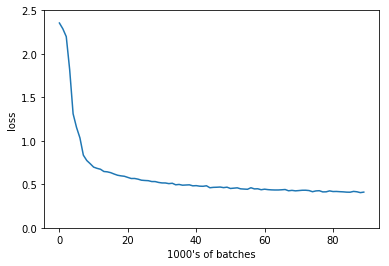

In [36]:
# visualize the loss as the netwokr trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

#### Test the Trained Network
Once you are satisfied with how the loss of your model has decreased, there is one last step: test!

You must test your trained model on a previously unseen dataset to see if it generalizes well and cna accurately classify this new dataset. For FashionMNIST, which contains many pre-processed training images, a good model should reach greater than 85% accuracy on this test dataset. If you are not reaching this value, try training for a larger number of epochs, tweaking hour